In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [2]:
nba_df = pd.read_csv("NBA_Data/NBA Player Stats(1950 - 2022).csv")
nba_df = nba_df[["Season", "Player", "G", "FG%", "3P%", "2P%", "MP", "PTS", "ORB", "DRB", "TRB", "AST", "STL", "BLK", "TOV"]]
                  

In [3]:
specific_player_df = nba_df.loc[(nba_df["Player"] == "LeBron James") | (nba_df["Player"] == "Michael Jordan")]
specific_player_df.head()

,Season,Player,G,FG%,3P%,2P%,MP,PTS,ORB,DRB,TRB,AST,STL,BLK,TOV
7754,1985,Michael Jordan,82.0,0.515,0.173,0.526,3144.0,2313.0,167.0,367.0,534.0,481.0,196.0,69.0,291.0
8131,1986,Michael Jordan,18.0,0.457,0.167,0.474,451.0,408.0,23.0,41.0,64.0,53.0,37.0,21.0,45.0
8505,1987,Michael Jordan,82.0,0.482,0.182,0.491,3281.0,3041.0,166.0,264.0,430.0,377.0,236.0,125.0,272.0
8904,1988,Michael Jordan,82.0,0.535,0.132,0.546,3311.0,2868.0,139.0,310.0,449.0,485.0,259.0,131.0,252.0
9331,1989,Michael Jordan,81.0,0.538,0.276,0.553,3255.0,2633.0,149.0,503.0,652.0,650.0,234.0,65.0,290.0


In [4]:
#Lifetime Total Stats of each player (as of 2022 LeBron James/seasons)
total_games = specific_player_df["G"].groupby(specific_player_df["Player"]).sum()
total_mins = specific_player_df["MP"].groupby(specific_player_df["Player"]).sum()
total_pts = specific_player_df["PTS"].groupby(specific_player_df["Player"]).sum()
total_reb = specific_player_df["TRB"].groupby(specific_player_df["Player"]).sum()
total_ast = specific_player_df["AST"].groupby(specific_player_df["Player"]).sum()
total_stl = specific_player_df["STL"].groupby(specific_player_df["Player"]).sum()
total_blk = specific_player_df["BLK"].groupby(specific_player_df["Player"]).sum()
total_tov = specific_player_df["TOV"].groupby(specific_player_df["Player"]).sum()
total_summary_df = pd.DataFrame({"Total Games Played": total_games, "Total Mins Played": total_mins, "Total Points Scored": total_pts,
                           "Total Rebounds": total_reb, "Total Assists": total_ast, "Total Steals": total_stl, "Total Blocks": total_blk, 
                           "Total Turnovers": total_tov})
total_summary_df

,Total Games Played,Total Mins Played,Total Points Scored,Total Rebounds,Total Assists,Total Steals,Total Blocks,Total Turnovers
Player,,,,,,,,
LeBron James,1366.0,52139.0,37062.0,10210.0,10045.0,2136.0,1041.0,4788.0
Michael Jordan,1072.0,41011.0,32292.0,6672.0,5633.0,2514.0,893.0,2924.0


In [5]:
#Lifetime Average Stats of each player (as of 2022 LeBron James/seasons)
mean_games = specific_player_df["G"].groupby(specific_player_df["Player"]).mean()
mean_fgp = specific_player_df["FG%"].groupby(specific_player_df["Player"]).mean()
mean_3pc = specific_player_df["3P%"].groupby(specific_player_df["Player"]).mean()
mean_2pc = specific_player_df["2P%"].groupby(specific_player_df["Player"]).mean()
mean_mins = specific_player_df["MP"].groupby(specific_player_df["Player"]).mean()
mean_pts = specific_player_df["PTS"].groupby(specific_player_df["Player"]).mean()
mean_reb = specific_player_df["TRB"].groupby(specific_player_df["Player"]).mean()
mean_ast = specific_player_df["AST"].groupby(specific_player_df["Player"]).mean()
mean_stl = specific_player_df["STL"].groupby(specific_player_df["Player"]).mean()
mean_blk = specific_player_df["BLK"].groupby(specific_player_df["Player"]).mean()
mean_tov = specific_player_df["TOV"].groupby(specific_player_df["Player"]).mean()
mean_summary_df = pd.DataFrame({"Avg. Games Played": mean_games, "Avg. Mins Played": mean_mins, "Avg. Points Scored": mean_pts,
                                "Avg. Field Goal %": mean_fgp, "Avg. 3 Point %": mean_3pc, "Avg. 2 Point %": mean_2pc,
                           "Avg. Rebounds": mean_reb, "Avg. Assists": mean_ast, "Avg. Steals": mean_stl, "Avg. Blocks": mean_blk, 
                           "Avg. Turnovers": mean_tov})
mean_summary_df

,Avg. Games Played,Avg. Mins Played,Avg. Points Scored,Avg. Field Goal %,Avg. 3 Point %,Avg. 2 Point %,Avg. Rebounds,Avg. Assists,Avg. Steals,Avg. Blocks,Avg. Turnovers
Player,,,,,,,,,,,
LeBron James,71.894737,2744.157895,1950.631579,0.506947,0.345684,0.558211,537.368421,528.684211,112.421053,54.789474,252.000000
Michael Jordan,71.466667,2734.066667,2152.800000,0.488267,0.283933,0.500667,444.800000,375.533333,167.600000,59.533333,194.933333


In [6]:
mj_specific_player_df = specific_player_df.loc[(specific_player_df["Player"] == "Michael Jordan")]
mj_efficiency = mj_specific_player_df["PTS"] / mj_specific_player_df["MP"]
mj_efficiency = mj_efficiency.reset_index(drop = True)
mj_efficiency

0     0.735687
1     0.904656
2     0.926852
3     0.866204
4     0.808909
5     0.861120
6     0.850363
7     0.774984
8     0.828497
9     0.684132
10    0.806149
11    0.782679
12    0.740962
13    0.656952
14    0.541076
dtype: float64

In [7]:
lj_specific_player_df = specific_player_df.loc[(specific_player_df["Player"] == "LeBron James")]
lj_efficiency = lj_specific_player_df["PTS"] / lj_specific_player_df["MP"]
lj_efficiency = lj_efficiency.reset_index(drop = True)
lj_efficiency

0     0.529789
1     0.641972
2     0.737281
3     0.668339
4     0.743310
5     0.754420
6     0.761295
7     0.689194
8     0.723560
9     0.707682
10    0.719848
11    0.699158
12    0.708749
13    0.699356
14    0.743886
15    0.776975
16    0.733161
17    0.748670
18    0.813340
dtype: float64

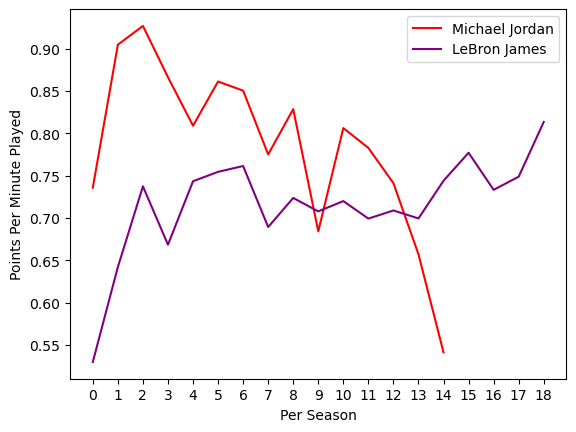

In [8]:
mj_plot, = plt.plot(range(len(mj_efficiency)), mj_efficiency, color="red", label="Michael Jordan")
lj_plot, = plt.plot(range(len(lj_efficiency)), lj_efficiency, color="purple", label="LeBron James")
plt.xticks(range(len(lj_efficiency)))
plt.xlabel("Per Season")
plt.ylabel("Points Per Minute Played")
plt.legend(handles=[mj_plot, lj_plot], loc="best")
plt.savefig("Charts/efficiency_pts_min.png") 
plt.show()



In [9]:
each_game_stats = pd.read_csv("NBA_Data/MJ_LJ_Games.csv")
each_game_stats.head()  

,Unnamed: 0.1,Unnamed: 0,Season,Game_ID,PLAYER_NAME,Team,GAME_DATE,MATCHUP,WL,MIN,...,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE
0,397858,634676,1984,28400019,Michael Jordan,CHI,"OCT 29, 1984",CHI vs. MIL,W,34,...,2.0,4.0,5.0,6.0,2.0,3.0,4.0,37,NaN,0
1,397859,634675,1984,28400025,Michael Jordan,CHI,"OCT 30, 1984",CHI @ KCK,W,36,...,2.0,4.0,5.0,3.0,1.0,6.0,5.0,25,NaN,0
2,397860,634674,1984,28400035,Michael Jordan,CHI,"NOV 01, 1984",CHI @ DEN,L,33,...,2.0,5.0,5.0,1.0,1.0,2.0,4.0,17,NaN,0
3,397861,634677,1984,28400013,Michael Jordan,CHI,"OCT 27, 1984",CHI @ MIL,L,34,...,2.0,5.0,5.0,2.0,1.0,3.0,4.0,21,NaN,0
4,397862,634678,1984,28400005,Michael Jordan,CHI,"OCT 26, 1984",CHI vs. WAS,W,40,...,5.0,6.0,7.0,2.0,4.0,5.0,2.0,16,NaN,0


In [10]:
each_game_stats.rename(columns={"PLAYER_NAME": "Player", "FG_PCT": "FG%", "FG3_PCT": "3P%"}, inplace=True)
each_game_stats

,Unnamed: 0.1,Unnamed: 0,Season,Game_ID,Player,Team,GAME_DATE,MATCHUP,WL,MIN,...,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE
0,397858,634676,1984,28400019,Michael Jordan,CHI,"OCT 29, 1984",CHI vs. MIL,W,34,...,2.0,4.0,5.0,6.0,2.0,3.0,4.0,37,NaN,0
1,397859,634675,1984,28400025,Michael Jordan,CHI,"OCT 30, 1984",CHI @ KCK,W,36,...,2.0,4.0,5.0,3.0,1.0,6.0,5.0,25,NaN,0
2,397860,634674,1984,28400035,Michael Jordan,CHI,"NOV 01, 1984",CHI @ DEN,L,33,...,2.0,5.0,5.0,1.0,1.0,2.0,4.0,17,NaN,0
3,397861,634677,1984,28400013,Michael Jordan,CHI,"OCT 27, 1984",CHI @ MIL,L,34,...,2.0,5.0,5.0,2.0,1.0,3.0,4.0,21,NaN,0
4,397862,634678,1984,28400005,Michael Jordan,CHI,"OCT 26, 1984",CHI vs. WAS,W,40,...,5.0,6.0,7.0,2.0,4.0,5.0,2.0,16,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2486,1304719,580724,2023,22200705,LeBron James,LAL,"JAN 22, 2023",LAL @ POR,W,36,...,11.0,11.0,4.0,0.0,2.0,4.0,2.0,37,17.0,1
2487,1304720,580710,2023,22201171,LeBron James,LAL,"APR 02, 2023",LAL @ HOU,W,29,...,8.0,10.0,11.0,0.0,1.0,1.0,1.0,18,23.0,1
2488,1304721,580708,2023,22201196,LeBron James,LAL,"APR 05, 2023",LAL @ LAC,NaN,36,...,8.0,8.0,6.0,1.0,1.0,5.0,0.0,27,-12.0,0
2489,1304722,580713,2023,22201114,LeBron James,LAL,"MAR 26, 2023",LAL vs. CHI,L,30,...,7.0,8.0,3.0,0.0,0.0,5.0,2.0,19,4.0,1


In [11]:
each_game_stats = each_game_stats[["Season", "Player", "MATCHUP", "WL", "PTS", "FG%", "OREB", "DREB", "AST", "STL", "BLK", "TOV"]]
each_game_stats.head()

,Season,Player,MATCHUP,WL,PTS,FG%,OREB,DREB,AST,STL,BLK,TOV
0,1984,Michael Jordan,CHI vs. MIL,W,37,0.542,2.0,2.0,5.0,6.0,2.0,3.0
1,1984,Michael Jordan,CHI @ KCK,W,25,0.381,2.0,2.0,5.0,3.0,1.0,6.0
2,1984,Michael Jordan,CHI @ DEN,L,17,0.467,3.0,2.0,5.0,1.0,1.0,2.0
3,1984,Michael Jordan,CHI @ MIL,L,21,0.615,3.0,2.0,5.0,2.0,1.0,3.0
4,1984,Michael Jordan,CHI vs. WAS,W,16,0.313,1.0,5.0,7.0,2.0,4.0,5.0


In [12]:
#Check for na values
each_game_stats.count()

Season     2491
Player     2491
MATCHUP    2491
WL         2490
PTS        2491
FG%        2491
OREB       2491
DREB       2491
AST        2491
STL        2491
BLK        2491
TOV        2491
dtype: int64

In [13]:
each_game_stats.dropna(inplace=True)

C:\Users\KANO\AppData\Local\Temp\ipykernel_15672\3851967206.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  each_game_stats.dropna(inplace=True)


In [14]:
each_game_stats.count()

Season     2490
Player     2490
MATCHUP    2490
WL         2490
PTS        2490
FG%        2490
OREB       2490
DREB       2490
AST        2490
STL        2490
BLK        2490
TOV        2490
dtype: int64

In [15]:
#Lifetime Points Stats (Offensive/each game)
mean_pts = each_game_stats["PTS"].groupby(each_game_stats["Player"]).mean()
median_pts = each_game_stats["PTS"].groupby(each_game_stats["Player"]).median()
var_pts = each_game_stats["PTS"].groupby(each_game_stats["Player"]).var()
std_dev_pts = each_game_stats["PTS"].groupby(each_game_stats["Player"]).std()
std_err_pts = each_game_stats["PTS"].groupby(each_game_stats["Player"]).sem()

summary_lifetime_pts_df = pd.DataFrame({"Mean Points Scored": mean_pts, "Median Points Scored": median_pts, "Variance of Points Scored": var_pts,
                               "Std. Dev of Points Scored": std_dev_pts, "Std. Error of Points Scored": std_err_pts})
summary_lifetime_pts_df

,Mean Points Scored,Median Points Scored,Variance of Points Scored,Std. Dev of Points Scored,Std. Error of Points Scored
Player,,,,,
LeBron James,27.198166,27.0,61.422241,7.837234,0.208125
Michael Jordan,30.123134,30.0,95.101537,9.752002,0.297849


In [16]:
#Lifetime Field Goal % (Offensive/each game)
mean_fgp = each_game_stats["FG%"].groupby(each_game_stats["Player"]).mean()
median_fgp = each_game_stats["FG%"].groupby(each_game_stats["Player"]).median()
var_fgp = each_game_stats["FG%"].groupby(each_game_stats["Player"]).var()
std_dev_fgp = each_game_stats["FG%"].groupby(each_game_stats["Player"]).std()
std_err_fgp = each_game_stats["FG%"].groupby(each_game_stats["Player"]).sem()

summary_lifetime_fgp_df = pd.DataFrame({"Mean Field Goal %": mean_fgp, "Median Field Goal %": median_fgp, "Variance of Field Goal %": var_fgp,
                               "Std. Dev of Field Goal %": std_dev_fgp, "Std. Error of Field Goal %": std_err_fgp})
summary_lifetime_fgp_df

,Mean Field Goal %,Median Field Goal %,Variance of Field Goal %,Std. Dev of Field Goal %,Std. Error of Field Goal %
Player,,,,,
LeBron James,0.505638,0.5,0.012173,0.110329,0.002930
Michael Jordan,0.495741,0.5,0.011830,0.108767,0.003322


In [17]:
#Lifetime Offensive Rebounds (Offensive/each game)
mean_oreb = each_game_stats["OREB"].groupby(each_game_stats["Player"]).mean()
median_oreb = each_game_stats["OREB"].groupby(each_game_stats["Player"]).median()
var_oreb = each_game_stats["OREB"].groupby(each_game_stats["Player"]).var()
std_dev_oreb = each_game_stats["OREB"].groupby(each_game_stats["Player"]).std()
std_err_oreb = each_game_stats["OREB"].groupby(each_game_stats["Player"]).sem()

summary_lifetime_oreb_df = pd.DataFrame({"Mean Offensive Rebounds": mean_oreb, "Median Offensive Rebounds": median_oreb,
                                     "Variance of Offensive Rebounds": var_oreb, "Std. Dev of Offensive Rebounds": std_dev_oreb,
                                     "Std. Error of Offensive Rebounds": std_err_oreb})
summary_lifetime_oreb_df

,Mean Offensive Rebounds,Median Offensive Rebounds,Variance of Offensive Rebounds,Std. Dev of Offensive Rebounds,Std. Error of Offensive Rebounds
Player,,,,,
LeBron James,1.174189,1.0,1.370484,1.170677,0.031088
Michael Jordan,1.555970,1.0,2.080898,1.442532,0.044058


In [18]:
#Lifetime Assists (Offensive/each game)
mean_ast = each_game_stats["AST"].groupby(each_game_stats["Player"]).mean()
median_ast = each_game_stats["AST"].groupby(each_game_stats["Player"]).median()
var_ast = each_game_stats["AST"].groupby(each_game_stats["Player"]).var()
std_dev_ast = each_game_stats["AST"].groupby(each_game_stats["Player"]).std()
std_err_ast = each_game_stats["AST"].groupby(each_game_stats["Player"]).sem()

summary_lifetime_ast_df = pd.DataFrame({"Mean Assists": mean_ast, "Median Assists": median_ast,
                                     "Variance of Assists": var_ast, "Std. Dev of Assists": std_dev_ast,
                                     "Std. Error of Assists": std_err_ast})
summary_lifetime_ast_df

,Mean Assists,Median Assists,Variance of Assists,Std. Dev of Assists,Std. Error of Assists
Player,,,,,
LeBron James,7.334979,7.0,8.790321,2.964848,0.078734
Michael Jordan,5.254664,5.0,7.413143,2.722709,0.083158


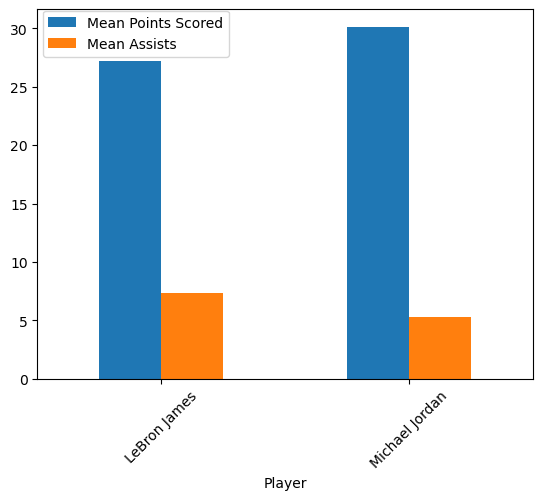

In [43]:
combined_offensive1 = pd.merge(summary_lifetime_pts_df, summary_lifetime_ast_df, on ="Player")
mean_values_chart1 = combined_offensive1[["Mean Points Scored", "Mean Assists"]]
mean_values_chart1.plot(kind="bar")
plt.xticks(rotation = 45)
plt.legend(loc="upper right", bbox_to_anchor=(0.4, 1.015))
plt.savefig("Charts/offensive_pts_ast.png") 
plt.show()

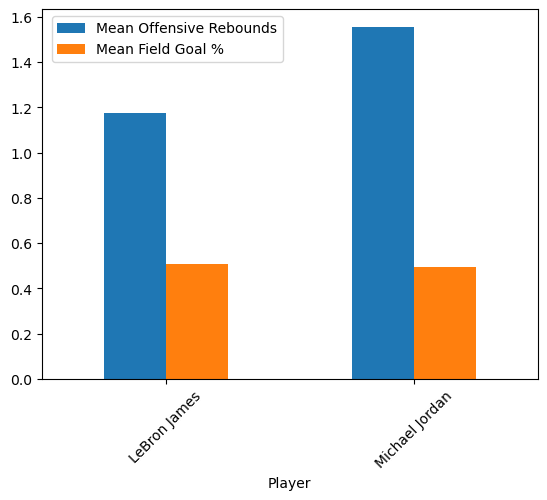

In [44]:
combined_offensive2 = pd.merge(summary_lifetime_oreb_df, summary_lifetime_fgp_df, on ="Player")
mean_values_chart2 = combined_offensive2[["Mean Offensive Rebounds", "Mean Field Goal %"]]
mean_values_chart2.plot(kind="bar")
plt.xticks(rotation = 45)
plt.legend(loc="upper right", bbox_to_anchor=(0.50, 1))
plt.savefig("Charts/offensive_reb_fgp.png") 
plt.show()

In [21]:
#Lifetime Defensive Rebounds (Defensive/each game)
mean_dreb = each_game_stats["DREB"].groupby(each_game_stats["Player"]).mean()
median_dreb = each_game_stats["DREB"].groupby(each_game_stats["Player"]).median()
var_dreb = each_game_stats["DREB"].groupby(each_game_stats["Player"]).var()
std_dev_dreb = each_game_stats["DREB"].groupby(each_game_stats["Player"]).std()
std_err_dreb = each_game_stats["DREB"].groupby(each_game_stats["Player"]).sem()

summary_lifetime_dreb_df = pd.DataFrame({"Mean Defensive Rebounds": mean_dreb, "Median Defensive Rebounds": median_dreb,
                                     "Variance of Defensive Rebounds": var_dreb, "Std. Dev of Defensive Rebounds": std_dev_dreb,
                                     "Std. Error of Defensive Rebounds": std_err_dreb})
summary_lifetime_dreb_df

,Mean Defensive Rebounds,Median Defensive Rebounds,Variance of Defensive Rebounds,Std. Dev of Defensive Rebounds,Std. Error of Defensive Rebounds
Player,,,,,
LeBron James,6.334274,6.0,7.406884,2.721559,0.072274
Michael Jordan,4.667910,4.0,6.602966,2.569624,0.078482


In [22]:
#Lifetime Steals (Defensive/each game)
mean_stl = each_game_stats["STL"].groupby(each_game_stats["Player"]).mean()
median_stl = each_game_stats["STL"].groupby(each_game_stats["Player"]).median()
var_stl = each_game_stats["STL"].groupby(each_game_stats["Player"]).var()
std_dev_stl = each_game_stats["STL"].groupby(each_game_stats["Player"]).std()
std_err_stl = each_game_stats["STL"].groupby(each_game_stats["Player"]).sem()

summary_lifetime_stl_df = pd.DataFrame({"Mean Steals": mean_stl, "Median Steals": median_stl,
                                     "Variance of Steals": var_stl, "Std. Dev of Steals": std_dev_stl,
                                     "Std. Error of Steals": std_err_stl})
summary_lifetime_stl_df

,Mean Steals,Median Steals,Variance of Steals,Std. Dev of Steals,Std. Error of Steals
Player,,,,,
LeBron James,1.540197,1.0,1.644466,1.282367,0.034054
Michael Jordan,2.345149,2.0,2.743506,1.656353,0.050589


In [23]:
#Lifetime Blocks (Defensive/each game)
mean_blk = each_game_stats["BLK"].groupby(each_game_stats["Player"]).mean()
median_blk = each_game_stats["BLK"].groupby(each_game_stats["Player"]).median()
var_blk = each_game_stats["BLK"].groupby(each_game_stats["Player"]).var()
std_dev_blk = each_game_stats["BLK"].groupby(each_game_stats["Player"]).std()
std_err_blk = each_game_stats["BLK"].groupby(each_game_stats["Player"]).sem()

summary_lifetime_blk_df = pd.DataFrame({"Mean Blocks": mean_blk, "Median Blocks": median_blk,
                                     "Variance of Blocks": var_blk, "Std. Dev of Blocks": std_dev_blk,
                                     "Std. Error of Blocks": std_err_blk})
summary_lifetime_blk_df

,Mean Blocks,Median Blocks,Variance of Blocks,Std. Dev of Blocks,Std. Error of Blocks
Player,,,,,
LeBron James,0.755289,1.0,0.808811,0.899339,0.023883
Michael Jordan,0.833022,1.0,1.022513,1.011194,0.030884


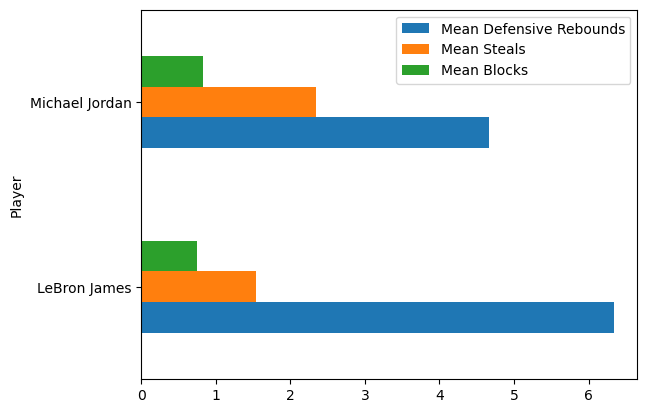

In [45]:
combined_def_stats = pd.merge(summary_lifetime_dreb_df, summary_lifetime_stl_df, on="Player")
combined_def_stats = pd.merge(combined_def_stats, summary_lifetime_blk_df, on="Player")
mean_def_chart = combined_def_stats[["Mean Defensive Rebounds", "Mean Steals", "Mean Blocks"]]
mean_def_chart.plot.barh()
plt.legend(loc="upper left", bbox_to_anchor=(0.50, 1))
plt.savefig("Charts/deffensive_stats.png") 
plt.show()

In [25]:
#Lifetime Turnover (misc/each game)
mean_tov = each_game_stats["TOV"].groupby(each_game_stats["Player"]).mean()
median_tov = each_game_stats["TOV"].groupby(each_game_stats["Player"]).median()
var_tov = each_game_stats["TOV"].groupby(each_game_stats["Player"]).var()
std_dev_tov = each_game_stats["TOV"].groupby(each_game_stats["Player"]).std()
std_err_tov = each_game_stats["TOV"].groupby(each_game_stats["Player"]).sem()

summary_lifetime_tov_df = pd.DataFrame({"Mean Turnovers": mean_tov, "Median Turnovers": median_tov,
                                     "Variance of Turnovers": var_tov, "Std. Dev of Turnovers": std_dev_tov,
                                     "Std. Error of Turnovers": std_err_tov})
summary_lifetime_tov_df

,Mean Turnovers,Median Turnovers,Variance of Turnovers,Std. Dev of Turnovers,Std. Error of Turnovers
Player,,,,,
LeBron James,3.492948,3.0,3.310113,1.819371,0.048315
Michael Jordan,2.727612,3.0,3.005101,1.733523,0.052946


In [26]:
mj_stats = each_game_stats.loc[each_game_stats["Season"] == 1991]
mj_stats

,Season,Player,MATCHUP,WL,PTS,FG%,OREB,DREB,AST,STL,BLK,TOV
456,1991,Michael Jordan,CHI @ MIA,W,26,0.450,2.0,3.0,5.0,3.0,0.0,2.0
457,1991,Michael Jordan,CHI @ CHH,W,41,0.682,3.0,2.0,5.0,4.0,2.0,4.0
458,1991,Michael Jordan,CHI vs. DET,W,18,0.400,2.0,1.0,1.0,2.0,0.0,2.0
459,1991,Michael Jordan,CHI vs. PHL,W,26,0.611,1.0,4.0,4.0,3.0,1.0,2.0
460,1991,Michael Jordan,CHI @ MIL,L,46,0.655,0.0,3.0,3.0,5.0,1.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
532,1991,Michael Jordan,CHI vs. CLE,W,30,0.462,1.0,2.0,4.0,4.0,3.0,3.0
533,1991,Michael Jordan,CHI vs. NJN,W,41,0.643,2.0,4.0,4.0,2.0,2.0,1.0
534,1991,Michael Jordan,CHI @ HOU,L,32,0.591,0.0,3.0,7.0,3.0,1.0,4.0
535,1991,Michael Jordan,CHI vs. ATL,W,31,0.522,0.0,6.0,6.0,2.0,1.0,5.0


In [27]:
#PTS stats when MJ won championship 1991 (age 27) **offensive stats
mean_pts_mj = mj_stats["PTS"].groupby(mj_stats["Player"]).mean() 
median_pts_mj = mj_stats["PTS"].groupby(mj_stats["Player"]).median()
var_pts_mj = mj_stats["PTS"].groupby(mj_stats["Player"]).var()
std_dev_pts_mj = mj_stats["PTS"].groupby(mj_stats["Player"]).std()
std_err_pts_mj = mj_stats["PTS"].groupby(mj_stats["Player"]).sem()

summary_1991_pts_df = pd.DataFrame({"Mean Points Scored": mean_pts_mj, "Median Points Scored": median_pts_mj, "Variance of Points Scored": var_pts_mj,
                               "Std. Dev of Points Scored": std_dev_pts_mj, "Std. Error of Points Scored": std_err_pts_mj})
summary_1991_pts_df

,Mean Points Scored,Median Points Scored,Variance of Points Scored,Std. Dev of Points Scored,Std. Error of Points Scored
Player,,,,,
Michael Jordan,31.074074,31.0,57.544444,7.585805,0.842867


In [28]:
#FG% stats when MJ won championship 1991 (age 27) **offensive stats
mean_fgp_mj = mj_stats["FG%"].groupby(mj_stats["Player"]).mean()
median_fgp_mj = mj_stats["FG%"].groupby(mj_stats["Player"]).median()
var_fgp_mj = mj_stats["FG%"].groupby(mj_stats["Player"]).var()
std_dev_fgp_mj = mj_stats["FG%"].groupby(mj_stats["Player"]).std()
std_err_fgp_mj = mj_stats["FG%"].groupby(mj_stats["Player"]).sem()

summary_1991_fgp_df = pd.DataFrame({"Mean Field Goal %": mean_fgp_mj, "Median Field Goal %": median_fgp_mj, "Variance of Field Goal %": var_fgp_mj,
                               "Std. Dev of Field Goal %": std_dev_fgp_mj, "Std. Error of Field Goal %": std_err_fgp_mj})
summary_1991_fgp_df

,Mean Field Goal %,Median Field Goal %,Variance of Field Goal %,Std. Dev of Field Goal %,Std. Error of Field Goal %
Player,,,,,
Michael Jordan,0.528148,0.542,0.01041,0.102028,0.011336


In [29]:
#OREB stats when MJ won championship 1991 (age 27) **offensive stats
mean_oreb_mj = mj_stats["OREB"].groupby(mj_stats["Player"]).mean()
median_oreb_mj = mj_stats["OREB"].groupby(mj_stats["Player"]).median()
var_oreb_mj = mj_stats["OREB"].groupby(mj_stats["Player"]).var()
std_dev_oreb_mj = mj_stats["OREB"].groupby(mj_stats["Player"]).std()
std_err_oreb_mj = mj_stats["OREB"].groupby(mj_stats["Player"]).sem()

summary_1991_oreb_df = pd.DataFrame({"Mean Offensive Rebounds": mean_oreb_mj, "Median Offensive Rebounds": median_oreb_mj,
                                     "Variance of Offensive Rebounds": var_oreb_mj, "Std. Dev of Offensive Rebounds": std_dev_oreb_mj,
                                     "Std. Error of Offensive Rebounds": std_err_oreb_mj})
summary_1991_oreb_df

,Mean Offensive Rebounds,Median Offensive Rebounds,Variance of Offensive Rebounds,Std. Dev of Offensive Rebounds,Std. Error of Offensive Rebounds
Player,,,,,
Michael Jordan,1.123457,1.0,1.259568,1.122305,0.124701


In [30]:
#AST stats when MJ won championship 1991 (age 27) **offensive stats
mean_ast_mj = mj_stats["AST"].groupby(mj_stats["Player"]).mean()
median_ast_mj = mj_stats["AST"].groupby(mj_stats["Player"]).median()
var_ast_mj = mj_stats["AST"].groupby(mj_stats["Player"]).var()
std_dev_ast_mj = mj_stats["AST"].groupby(mj_stats["Player"]).std()
std_err_ast_mj = mj_stats["AST"].groupby(mj_stats["Player"]).sem()

summary_1991_ast_df = pd.DataFrame({"Mean Assists": mean_oreb_mj, "Median Assists": median_oreb_mj,
                                     "Variance of Assists": var_oreb_mj, "Std. Dev of Assists": std_dev_oreb_mj,
                                     "Std. Error of Assists": std_err_oreb_mj})
summary_1991_ast_df

,Mean Assists,Median Assists,Variance of Assists,Std. Dev of Assists,Std. Error of Assists
Player,,,,,
Michael Jordan,1.123457,1.0,1.259568,1.122305,0.124701


In [31]:
#TOV stats when MJ won championship 1991 (age 27) **offensive stats
mean_tov_mj = mj_stats["TOV"].groupby(mj_stats["Player"]).mean()
median_tov_mj = mj_stats["TOV"].groupby(mj_stats["Player"]).median()
var_tov_mj = mj_stats["TOV"].groupby(mj_stats["Player"]).var()
std_dev_tov_mj = mj_stats["TOV"].groupby(mj_stats["Player"]).std()
std_err_tov_mj = mj_stats["TOV"].groupby(mj_stats["Player"]).sem()

summary_1991_tov_df = pd.DataFrame({"Mean Turnovers": mean_tov_mj, "Median Turnovers": median_tov_mj,
                                     "Variance of Turnovers": var_tov_mj, "Std. Dev of Turnovers": std_dev_tov_mj,
                                     "Std. Error of Turnovers": std_err_tov_mj})
summary_1991_tov_df

,Mean Turnovers,Median Turnovers,Variance of Turnovers,Std. Dev of Turnovers,Std. Error of Turnovers
Player,,,,,
Michael Jordan,2.604938,2.0,3.091975,1.758401,0.195378


In [32]:
lj_stats = each_game_stats.loc[each_game_stats["Season"] == 2012]
lj_stats

,Season,Player,MATCHUP,WL,PTS,FG%,OREB,DREB,AST,STL,BLK,TOV
1703,2012,LeBron James,MIA vs. PHX,W,20,0.444,1.0,7.0,6.0,2.0,2.0,3.0
1704,2012,LeBron James,MIA vs. ORL,W,14,0.286,0.0,12.0,7.0,5.0,0.0,4.0
1705,2012,LeBron James,MIA @ PHI,W,29,0.600,2.0,5.0,8.0,2.0,2.0,1.0
1706,2012,LeBron James,MIA @ CHI,L,35,0.560,1.0,4.0,4.0,4.0,0.0,2.0
1707,2012,LeBron James,MIA @ DET,W,17,0.400,0.0,6.0,10.0,4.0,1.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1785,2012,LeBron James,MIA vs. CHA,W,16,0.600,0.0,9.0,5.0,1.0,0.0,2.0
1786,2012,LeBron James,MIA @ LAC,L,23,0.368,2.0,11.0,7.0,2.0,0.0,6.0
1787,2012,LeBron James,MIA @ GSW,L,26,0.526,1.0,10.0,7.0,2.0,0.0,5.0
1788,2012,LeBron James,MIA @ NJN,W,32,0.647,0.0,7.0,9.0,2.0,1.0,8.0


In [33]:
#PTS stats when LJ won championship 2012 (age 28) **offensive stats
mean_pts_lj = lj_stats["PTS"].groupby(lj_stats["Player"]).mean()
median_pts_lj = lj_stats["PTS"].groupby(lj_stats["Player"]).median()
var_pts_lj = lj_stats["PTS"].groupby(lj_stats["Player"]).var()
std_dev_pts_lj = lj_stats["PTS"].groupby(lj_stats["Player"]).std()
std_err_pts_lj = lj_stats["PTS"].groupby(lj_stats["Player"]).sem()

summary_2012_pts_df = pd.DataFrame({"Mean Points Scored": mean_pts_lj, "Median Points Scored": median_pts_lj, "Variance of Points Scored": var_pts_lj,
                               "Std. Dev of Points Scored": std_dev_pts_lj, "Std. Error of Points Scored": std_err_pts_lj})
summary_2012_pts_df

,Mean Points Scored,Median Points Scored,Variance of Points Scored,Std. Dev of Points Scored,Std. Error of Points Scored
Player,,,,,
LeBron James,26.586207,26.0,38.594226,6.212425,0.666042


In [34]:
#FG% stats when LJ won championship 2012 (age 28) **offensive stats
mean_fgp_lj = lj_stats["FG%"].groupby(lj_stats["Player"]).mean()
median_fgp_lj = lj_stats["FG%"].groupby(lj_stats["Player"]).median()
var_fgp_lj = lj_stats["FG%"].groupby(lj_stats["Player"]).var()
std_dev_fgp_lj = lj_stats["FG%"].groupby(lj_stats["Player"]).std()
std_err_fgp_lj = lj_stats["FG%"].groupby(lj_stats["Player"]).sem()

summary_2012_fgp_df = pd.DataFrame({"Mean Field Goal %": mean_fgp_lj, "Median Field Goal %": median_fgp_lj, "Variance of Field Goal %": var_fgp_lj,
                               "Std. Dev of Field Goal %": std_dev_fgp_lj, "Std. Error of Field Goal %": std_err_fgp_lj})
summary_2012_fgp_df

,Mean Field Goal %,Median Field Goal %,Variance of Field Goal %,Std. Dev of Field Goal %,Std. Error of Field Goal %
Player,,,,,
LeBron James,0.535598,0.533,0.010336,0.101664,0.0109


In [35]:
#OREB stats when LJ won championship 2012 (age 28) **offensive stats
mean_oreb_lj = lj_stats["OREB"].groupby(lj_stats["Player"]).mean()
median_oreb_lj = lj_stats["OREB"].groupby(lj_stats["Player"]).median()
var_oreb_lj = lj_stats["OREB"].groupby(lj_stats["Player"]).var()
std_dev_oreb_lj = lj_stats["OREB"].groupby(lj_stats["Player"]).std()
std_err_oreb_lj = lj_stats["OREB"].groupby(lj_stats["Player"]).sem()

summary_2012_oreb_df = pd.DataFrame({"Mean Offensive Rebounds": mean_oreb_lj, "Median Offensive Rebounds": median_oreb_lj,
                                     "Variance of Offensive Rebounds": var_oreb_lj, "Std. Dev of Offensive Rebounds": std_dev_oreb_lj,
                                     "Std. Error of Offensive Rebounds": std_err_oreb_lj})
summary_2012_oreb_df

,Mean Offensive Rebounds,Median Offensive Rebounds,Variance of Offensive Rebounds,Std. Dev of Offensive Rebounds,Std. Error of Offensive Rebounds
Player,,,,,
LeBron James,1.471264,1.0,1.717188,1.310415,0.140491


In [36]:
#AST stats when LJ won championship 2012 (age 28) **offensive stats
mean_ast_lj = lj_stats["AST"].groupby(lj_stats["Player"]).mean()
median_ast_lj = lj_stats["AST"].groupby(lj_stats["Player"]).median()
var_ast_lj = lj_stats["AST"].groupby(lj_stats["Player"]).var()
std_dev_ast_lj = lj_stats["AST"].groupby(lj_stats["Player"]).std()
std_err_ast_lj = lj_stats["AST"].groupby(lj_stats["Player"]).sem()

summary_2012_ast_df = pd.DataFrame({"Mean Assists": mean_ast_lj, "Median Assists": median_ast_lj,
                                     "Variance of Assists": var_ast_lj, "Std. Dev of Assists": std_dev_ast_lj,
                                     "Std. Error of Assists": std_err_ast_lj})
summary_2012_ast_df

,Mean Assists,Median Assists,Variance of Assists,Std. Dev of Assists,Std. Error of Assists
Player,,,,,
LeBron James,6.45977,6.0,6.25127,2.500254,0.268055


In [37]:
#TOV stats when LJ won championship 2012 (age 28) **offensive stats
mean_tov_lj = lj_stats["TOV"].groupby(lj_stats["Player"]).mean()
median_tov_lj = lj_stats["TOV"].groupby(lj_stats["Player"]).median()
var_tov_lj = lj_stats["TOV"].groupby(lj_stats["Player"]).var()
std_dev_tov_lj = lj_stats["TOV"].groupby(lj_stats["Player"]).std()
std_err_tov_lj = lj_stats["TOV"].groupby(lj_stats["Player"]).sem()

summary_2012_tov_df = pd.DataFrame({"Mean Turnovers": mean_ast_lj, "Median Turnovers": median_ast_lj,
                                     "Variance of Turnovers": var_ast_lj, "Std. Dev of Turnovers": std_dev_ast_lj,
                                     "Std. Error of Turnovers": std_err_ast_lj})
summary_2012_tov_df

,Mean Turnovers,Median Turnovers,Variance of Turnovers,Std. Dev of Turnovers,Std. Error of Turnovers
Player,,,,,
LeBron James,6.45977,6.0,6.25127,2.500254,0.268055


In [38]:
champ_combined = pd.merge(summary_1991_pts_df, summary_2012_pts_df, how="outer")
champ_combined

,Mean Points Scored,Median Points Scored,Variance of Points Scored,Std. Dev of Points Scored,Std. Error of Points Scored
0,31.074074,31.0,57.544444,7.585805,0.842867
1,26.586207,26.0,38.594226,6.212425,0.666042
